# Categorização de Compras

# Importa Bibliotecas

In [1]:
from getpass import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from swat import *
import dlpy
from dlpy import *
from dlpy import Sequential
from dlpy.splitting import three_way_split
from dlpy.model import TextParms
from dlpy.blocks import Bidirectional
from dlpy.applications import TextClassification
from dlpy.metrics import accuracy_score, roc_auc_score, confusion_matrix
%matplotlib inline

# Connect to SAS Viya

In [2]:
sas = CAS('localhost', 5570, 'sasdemo', getpass('Please enter your passwod:'))

Please enter your passwod:········


# Load Action Sets

In [3]:
sas.loadactionset('fedSql')
sas.loadactionset('sampling')
print('Done!')

NOTE: Added action set 'fedSql'.
NOTE: Added action set 'sampling'.
Done!


# Load Data

In [4]:
des = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/ComprasDescID.csv',
                   sep=',',
                   quotechar='"',
                   casout=CASTable(name='des', replace=True))
print(des.columns)
print(des.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table DES in caslib CASUSER(sasdemo).
NOTE: The table DES has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['ID', 'DESCRI', 'NCM'], dtype='object')
(163933, 3)


In [5]:
des.head()

,ID,DESCRI,NCM
0,80230.0,OB-055 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,96032100.0
1,80231.0,OB-056 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,96032100.0
2,80232.0,OB-057 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,96032100.0
3,80233.0,OB-058 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,96032100.0
4,80234.0,OB-059 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,96032100.0


In [6]:
cat = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/ComprasCat2.csv',
                   sep=',',
                   quotechar='"',
                   casout=CASTable(name='cat', replace=True))
print(cat.columns)
print(cat.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table CAT in caslib CASUSER(sasdemo).
NOTE: The table CAT has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['ncm', 'cat'], dtype='object')
(6, 2)


In [7]:
cat.head()

,ncm,cat
0,33.0,ÓLEOS
1,34.0,SABÕES
2,96.0,OBRAS DIVERSAS
3,48.0,PAPÉIS
4,39.0,PLÁSTICOS


# Prepare Data

In [8]:
sas.fedsql.execdirect(
    '''
    create table data {options replace=True} as select
        a.ID as ID,
        a.DESCRI as DES,
        nvl(b.CAT,'OUTROS') as CAT
    from des as a
    left join cat as b
    on floor(a.NCM/1e6) = b.NCM
    '''
)
data = sas.CASTable('data')
print(data.columns)
print(data.shape)

NOTE: Table DATA was created in caslib CASUSER(sasdemo) with 163933 rows returned.
Index(['ID', 'DES', 'CAT'], dtype='object')
(163933, 3)


In [9]:
data.head()

,ID,DES,CAT
0,80230.0,OB-055 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,OBRAS DIVERSAS
1,80231.0,OB-056 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,OBRAS DIVERSAS
2,80232.0,OB-057 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,OBRAS DIVERSAS
3,80233.0,OB-058 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,OBRAS DIVERSAS
4,80234.0,OB-059 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,OBRAS DIVERSAS


In [10]:
sas.fedsql.execdirect(
    '''
    select cat, sum(1) as cnt from data group by cat order by cnt desc
    '''
)

,CAT,CNT
0,ÓLEOS,131954
1,SABÕES,11886
2,OBRAS DIVERSAS,9464
3,OUTROS,2971
4,PAPÉIS,2958
5,PLÁSTICOS,2505
6,FERRAMENTAS,2195


# Stratified Sampling

In [11]:
data.query('cat <> "ÓLEOS"') \
    .groupby('cat') \
    .stratified(output={'casOut':{'name':'work01', 'replace':True}, 'copyVars':'ALL'},
                samppct=80,
                samppct2=10,
                partind=True)

data.query('cat = "ÓLEOS"') \
    .stratified(output={'casOut':{'name':'work02', 'replace':True}, 'copyVars':'ALL'},
                samppct=10,
                partind=True)

sas.stratified(table=sas.CASTable('work02').query('_PartInd_ = 1'),
               output={'casOut':{'name':'work03', 'replace':True}, 'copyVars':['ID','DES','CAT']},
               samppct=80,
               samppct2=10,
               partind=True)

work01 = sas.CASTable('work01')
work03 = sas.CASTable('work03')
data = work01.append(work03, casout='data')
print(data.shape)

NOTE: Using SEED=1916804427 for sampling.
NOTE: Using SEED=623185916 for sampling.
NOTE: Using SEED=63077535 for sampling.
(45174, 4)


In [13]:
sas.fedsql.execdirect(
    '''
    select cat, sum(1) as cnt from data group by cat order by cnt desc
    '''
)

,CAT,CNT
0,ÓLEOS,13195
1,SABÕES,11886
2,OBRAS DIVERSAS,9464
3,OUTROS,2971
4,PAPÉIS,2958
5,PLÁSTICOS,2505
6,FERRAMENTAS,2195


# Load Embeddings

Repositório de Word Embeddings do NILC (Núcleo Interinstitucional de Linguística Computacional)
- http://nilc.icmc.usp.br/embeddings

In [ ]:
emb = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/glove_s50.txt',
                   sep=' ',
                   header=None,
                   skiprows=1,
                   casout=CASTable(name='emb', replace=True))
print(emb.columns)
print(emb.shape)

In [ ]:
emb.head()

# Train Model

In [ ]:
model = TextClassification(sas,
                           model_table='bdlstm001',
                           neurons=100,
                           n_blocks=1,
                           rnn_type='LSTM')

In [ ]:
model.plot_network()

In [ ]:
model.fit(data=data[data['_PartInd_']==0], 
          valid_table=data[data['_PartInd_']==1],
          inputs='des',
          texts='des',
          target='cat',
          nominals='cat',
          text_parms=TextParms(init_input_embeddings='emb', language='portuguese'),
          mini_batch_size=4, 
          max_epochs=100,
          lr=0.01,
          log_level=2)

In [ ]:
model.plot_training_history(tick_frequency=5)

In [ ]:
res = \
model.predict(data[data['_PartInd_']==2],
              text_parms=TextParms(init_input_embeddings='emb', model_output_embeddings='bdsltm001'),
              use_best_weights=True,
              top_probs=2)
preds = res['OutputCasTables']['casTable'][0]
print(res['ScoreInfo'])

In [ ]:
cmx = preds.crosstab(row='CAT', col='_DL_PredName_')
print(cmx.Crosstab)

# Train New Embeddings

In [14]:
sas.loadactionset('textMining')
sas.tmMine(docId="ID",
           documents="data", 
           entities="NONE",
           nounGroups=False,
           offset=dict(name='pos', replace=True),
           reduce=1,
           stemming=False,
           tagging=False,
           terms=dict(name='terms', replace=True),
           text="DES"
        )

NOTE: Added action set 'textMining'.


,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(sasdemo),pos,,262424,9,"CASTable('pos', caslib='CASUSER(sasdemo)')"
1,CASUSER(sasdemo),terms,,21370,11,"CASTable('terms', caslib='CASUSER(sasdemo)')"


In [15]:
sas.loadactionset('textUtil')
sas.tmCooccur(cooccurrence=dict(name='cooc', replace=True),
            maxDist=5,
            minCount=0,
            offset={"name":"pos"},
            ordered=False,
            terms={"name":"terms"},  
            useParentId=True
           )

NOTE: Added action set 'textUtil'.


[NObs]

 Input Data Statistics
 
                       Description     Value
 0   Number of sentences processed   47665.0
 1       Number of terms processed   21370.0
 2  Number of term pairs processed  617461.0

[OutputCasTablesFull]

              casLib  Name Label    Rows  Columns  \
 0  CASUSER(sasdemo)  cooc        436960        6   
 
                                       casTable  
 0  CASTable('cooc', caslib='CASUSER(sasdemo)')  

+ Elapsed: 2.74s, user: 3.09s, sys: 1.08s, mem: 152mb

In [16]:
sas.tmSvd(count="_association_",
        docId="_termid2_",
        maxK=50,
        parent={"name":"cooc"}, 
        termId="_termid1_",
        wordPro=dict(name='wordPro', replace=True)
       )

,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(sasdemo),wordPro,,21370,51,"CASTable('wordPro', caslib='CASUSER(sasdemo)')"


In [17]:
sas.execDirect(casout=dict(name='wordEmbedding', replace=True),
             query='select t._term_, d.* from wordPro d, terms t where d._termnum_=t._termnum_')

NOTE: Table wordEmbedding was created in caslib CASUSER(sasdemo) with 21370 rows returned.


+ Elapsed: 0.149s, user: 0.294s, sys: 0.102s, mem: 66.5mb

In [18]:
sas.datastep.runcode('data wordEmbedding(replace=yes); set wordEmbedding; drop _TermNum_; run;')

[InputCasTables]

              casLib           Name   Rows  Columns  \
 0  CASUSER(sasdemo)  wordEmbedding  21370       52   
 
                                             casTable  
 0  CASTable('wordEmbedding', caslib='CASUSER(sasd...  

[OutputCasTables]

              casLib           Name   Rows  Columns  Append  \
 0  CASUSER(sasdemo)  wordEmbedding  21370       51     NaN   
 
                                             casTable  
 0  CASTable('wordEmbedding', caslib='CASUSER(sasd...  

+ Elapsed: 0.0539s, user: 0.099s, sys: 0.035s, mem: 7.5mb

In [19]:
sas.CASTable('wordEmbedding').head()

,_Term_,_Col1_,_Col2_,_Col3_,_Col4_,_Col5_,_Col6_,_Col7_,_Col8_,_Col9_,...,_Col41_,_Col42_,_Col43_,_Col44_,_Col45_,_Col46_,_Col47_,_Col48_,_Col49_,_Col50_
0,adst2,0.302401,-0.179095,-0.269440,-0.233528,0.087033,0.053620,-0.059986,-0.065822,0.027693,...,-0.030305,-0.003509,-0.099825,0.148674,0.020010,-0.116575,0.043521,-0.012953,-0.257594,0.224465
1,e80gr,0.388314,0.039887,-0.171849,-0.347756,-0.069608,0.034213,0.125915,0.134440,-0.084221,...,-0.067970,0.280854,0.081228,0.072984,-0.217170,-0.191507,-0.007355,0.111472,-0.088817,0.033383
2,efeit,0.199837,-0.002537,0.194089,0.028786,0.088385,-0.110641,-0.080827,0.141533,0.257831,...,0.248109,-0.312510,-0.127455,-0.154488,0.035899,0.235613,-0.062220,-0.050346,-0.217597,0.142771
3,fired,0.170072,-0.058604,0.121378,0.072116,-0.015832,-0.089873,-0.080445,0.094140,0.284350,...,0.193184,-0.339570,0.048124,0.048584,-0.092374,0.263337,-0.053973,0.128996,-0.160409,0.180899
4,monet,0.360996,-0.242305,-0.010277,0.204622,0.000974,-0.064244,0.020460,0.069263,0.151883,...,0.342590,-0.135516,-0.062631,0.131355,0.025950,0.145692,-0.041331,0.008104,-0.229598,0.131597


# Visualize the New Word Embeddings

In [ ]:
sas.loadactionset("tSne")
sas.tSne(output        = {"casOut":{"name":"tsne", "replace":True},
                          "copyVars":'_Term_'},
         inputs        = ['_Col%d_' % x for x in range(1,51)],
         nDimensions   = 2,
         perplexity    = 5,
         learningRate  = 100,
         maxIters      = 500,
         table         = 'wordEmbedding')

tsne_out=sas.CASTable('tsne')

In [ ]:
#plot

# Train New Model

In [53]:
model = TextClassification(sas,
                           model_table='bdlstm002',
                           neurons=100,
                           n_blocks=3,
                           rnn_type='LSTM')

NOTE: Output layer added.
NOTE: Model compiled successfully.


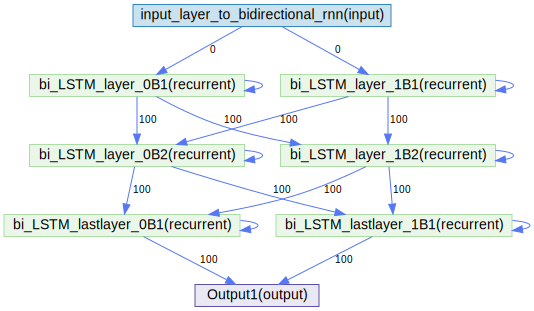

In [54]:
model.plot_network()

In [ ]:
model.fit(data=data[data['_PartInd_']==0], 
          valid_table=data[data['_PartInd_']==1],
          inputs='des',
          texts='des',
          target='cat',
          nominals='cat',
          text_parms=TextParms(init_input_embeddings='wordEmbedding', language='portuguese'),
          mini_batch_size=4, 
          max_epochs=100,
          lr=0.01,
          log_level=2)

NOTE: Training based on existing weights.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 605607.
NOTE:  The approximate memory cost is 58.00 MB.
NOTE:  Loading weights cost       0.01 (s).
NOTE:  Initializing each layer cost       7.08 (s).
NOTE:  The total number of threads on each worker is 10.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 40.
NOTE:  Target variable: CAT
NOTE:  Number of levels for the target variable:      7
NOTE:  Levels for the target variable:
NOTE:  Level      0: FERRAMENTAS   
NOTE:  Level      1: OBRAS DIVERSAS
NOTE:  Level      2: ÓLEOS        
NOTE:  Level      3: OUTROS        
NOTE:  Level      4: PAPÉIS       
NOTE:  Level      5: PLÁSTICOS    
NOTE:  Level      6: SABÕES       
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Lo

In [ ]:
model.plot_training_history(tick_frequency=5)

In [ ]:
res = \
model.predict(data[data['_PartInd_']==2],
              text_parms=TextParms(init_input_embeddings='wordEmbedding', model_output_embeddings='bdsltm002'),
              use_best_weights=True,
              top_probs=2)
preds = res['OutputCasTables']['casTable'][0]
print(res['ScoreInfo'])

In [ ]:
t = preds.tableinfo()['TableInfo']['Name'][0]
tmp = sas.CASTable('filtered')
for cat in ['FERRAMENTAS','OBRAS DIVERSAS','OUTROS','PAPÉIS','PLÁSTICOS','SABÕES','ÓLEOS']:
    sas.fedsql.execdirect('create table filtered {options replace=True} as select * from '+t+' where cat = \''+cat+'\'')
    acc = accuracy_score(tmp['CAT'], tmp['_DL_PredName_'], id_vars='ID')
    print('%s: %.4f' % (cat, acc))

In [ ]:
cmx = preds.crosstab(row='_DL_PredName_', col='CAT')
print(cmx.Crosstab)

# Save Models

In [49]:
model.save_to_table('/home/sasdemo/demos/nlpCompras/models/bdlstm002')

NOTE: Model table saved successfully.


# Save Predictions

In [50]:
sas.addcaslib(name='compras',
              path='/home/sasdemo/demos/nlpCompras/data',
              datasource='path',
              session=False)

NOTE: Caslib compras already exists.


ERROR: The action stopped due to errors.


+ Elapsed: 0.00171s, mem: 0.346mb

In [52]:
preds.save(caslib='compras', name='ComprasScored', replace=True)
# preds.to_csv('/home/sasdemo/demos/nlpCompras/data/ComprasScored.csv')

NOTE: Cloud Analytic Services saved the file ComprasScored.sashdat in caslib compras.


[caslib]

 'compras'

[name]

 'ComprasScored.sashdat'

+ Elapsed: 0.0124s, sys: 0.008s, mem: 16.5mb

# Terminate Session

In [ ]:
sas.terminate()

In [ ]:
model = TextClassification(sas,
                           model_table='bdlstm002',
                           neurons=100,
                           n_blocks=1,
                           rnn_type='LSTM')

In [ ]:
model.load('/home/sasdemo/demos/nlpCompras/models/bdlstm002/bdlstm002.sashdat')